In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0
Torchvision Version:  0.11.1


In [2]:
# 顶级数据目录。 这里我们假设目录的格式符合ImageFolder结构
data_dir = "../data/hymenoptera_data"

# 从[resnet, alexnet, vgg, squeezenet, densenet, inception]中选择模型
model_name = "squeezenet"

# 数据集中类别数量
num_classes = 2

# 训练的批量大小（根据您的内存量而变化）
batch_size = 8

# 你要训练的epoch数
num_epochs = 5

# 用于特征提取的标志。 当为False时，我们微调整个模型，
# 当True时我们只更新重新形成的图层参数
feature_extract = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def train_model(model,
                dataloaders,
                criterion,
                optimizer,
                num_epochs=25,
                is_inception=False):
    since = time.time()
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 零参数梯度
                optimizer.zero_grad()

                # 前向
                # 如果只在训练时则跟踪轨迹
                with torch.set_grad_enabled(phase == 'train'):
                    # 获取模型输出并计算损失
                    # 开始的特殊情况，因为在训练中它有一个辅助输出。
                    # 在训练模式下，我们通过将最终输出和辅助输出相加来计算损耗
                    # 但在测试中我们只考虑最终输出。
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double(
            ) / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [4]:
#### 3.2 设置模型参数的`.requires_grad`属性
# 当我们进行特征提取时，此辅助函数将模型中参数的 .requires_grad 属性设置为False。
# 默认情况下，当我们加载一个预训练模型时，所有参数都是 `.requires_grad = True`，如果我们从头开始训练或微调，这种设置就没问题。
# 但是，如果我们要运行特征提取并且只想为新初始化的层计算梯度，那么我们希望所有其他参数不需要梯度变化。这将在稍后更能理解。
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 初始化将在此if语句中设置的这些变量。
    # 每个变量都是模型特定的。
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
 """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
 """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
 """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
 """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(
            512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
 """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
 Be careful, expects (299,299) sized images and has auxiliary output
 """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # 处理辅助网络
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # 处理主要网络
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


# 在这步中初始化模型
model_ft, input_size = initialize_model(
    model_name, num_classes, feature_extract, use_pretrained=True)

# 打印我们刚刚实例化的模型
print(model_ft)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [6]:
# 数据扩充和训练规范化
# 只需验证标准化
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# 创建训练和验证数据集
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# 创建训练和验证数据加载器
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# 检测我们是否有可用的GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [7]:
# 将模型发送到GPU
model_ft = model_ft.to(device)

# 在此运行中收集要优化/更新的参数。 
# 如果我们正在进行微调，我们将更新所有参数。 
# 但如果我们正在进行特征提取方法，我们只会更新刚刚初始化的参数，即`requires_grad`的参数为True。
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# 观察所有参数都在优化
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [8]:
# 设置损失函数
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/4
----------
train Loss: 0.5292 Acc: 0.7541
val Loss: 0.3223 Acc: 0.8693

Epoch 1/4
----------
train Loss: 0.2355 Acc: 0.8811
val Loss: 0.2551 Acc: 0.9216

Epoch 2/4
----------
train Loss: 0.1990 Acc: 0.9221
val Loss: 0.2865 Acc: 0.9150

Epoch 3/4
----------
train Loss: 0.2378 Acc: 0.8975
val Loss: 0.4211 Acc: 0.8824

Epoch 4/4
----------
train Loss: 0.2009 Acc: 0.9262
val Loss: 0.2533 Acc: 0.9346

Training complete in 2m 37s
Best val Acc: 0.934641


Epoch 0/4
----------
train Loss: 0.7106 Acc: 0.5697
val Loss: 0.6931 Acc: 0.4575

Epoch 1/4
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 2/4
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 3/4
----------
train Loss: 0.6931 Acc: 0.5041
val Loss: 0.6931 Acc: 0.4575

Epoch 4/4
----------
train Loss: 0.6931 Acc: 0.5082
val Loss: 0.6931 Acc: 0.4575

Training complete in 4m 35s
Best val Acc: 0.457516


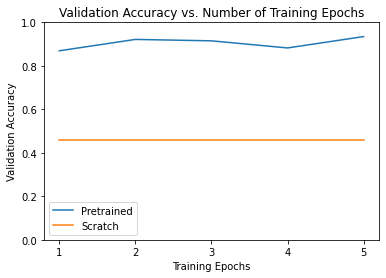

In [9]:
# 初始化用于此运行的模型的非预训练版本
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# 绘制验证精度的训练曲线与转移学习方法
# 和从头开始训练的模型的训练epochs的数量
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()